In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 1. 生成数据集

# 生成合成数据集函数，y = Xw + b + 噪声
def synthetic_data(w, b, num_examples):  #@save
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b   # y = Xw + b
    y += torch.normal(0, 0.01, y.shape) # 服从正态分布的噪声，标准差为0.01
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.1929, -0.3491]) 
label: tensor([5.7708])


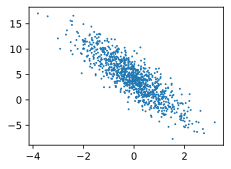

In [2]:
# 生成散点图进行观察
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [3]:
# 2. 读取数据集

# 定义一个能够小批量方式随机获取数据集中的样本的函数，获取 batch_size 个随机样本
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机读取的
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
# 读取一个小批量样本并打印查看
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.6246, -0.6350],
        [-0.1802,  2.0015],
        [ 1.5046, -0.0738],
        [ 1.4626, -1.4723],
        [-1.0150, -0.1745],
        [ 0.1929, -0.3491],
        [-1.5134,  1.2137],
        [-0.1614,  0.0232],
        [ 0.2939, -0.8616],
        [-0.2807,  0.9542]]) 
 tensor([[ 9.5912],
        [-2.9610],
        [ 7.4576],
        [12.1301],
        [ 2.7670],
        [ 5.7708],
        [-2.9480],
        [ 3.7859],
        [ 7.7146],
        [ 0.3801]])


In [4]:
# 3. 初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 从 N ~ （0，0.01）中抽样随机数初始化
b = torch.zeros(1, requires_grad=True) # 初始化为0

# 4. 线性回归模型 y = Xw + b
def linreg(X, w, b):  #@save
    return torch.matmul(X, w) + b

# 5. 损失函数
def squared_loss(y_hat, y):  #@save
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 需要转化两者形状相同

# 6. 优化算法——小批量随机梯度下降
# 输入模型参数、学习率（每一步更新的大小）、批量大小
def sgd(params, lr, batch_size):  #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 除以批量大小来规范化步长
            param.grad.zero_()

In [5]:
# 7. 训练

# 超参数
lr = 0.03 # 学习率
num_epochs = 3 # 轮数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失l；因为l形状是(batch_size,1)，而不是一个标量
        l.sum().backward() # l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.026834
epoch 2, loss 0.000088
epoch 3, loss 0.000047


In [6]:
# 与真实值比较
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0001, -0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)
